# fMRI INR

In [27]:
import os
import pandas as pd
from PIL import Image
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import os
from einops import rearrange, repeat
import einops
from glob import glob
from math import log
import math
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import nibabel as nib
import nilearn as nil
from nilearn.image import index_img

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load Data

In [29]:
###- DS LOCATION CONFIRMATION -###

jubin_ds = "/home/idies/workspace/Temporary/ecardillo/scratch/fmri/jubin-ds.nii"

# verify the file exists
if os.path.exists(jubin_ds):
    print(f"YES! File found at: {jubin_ds}")
else:
    print(f"Error: File not found at: {jubin_ds}")
    
# loads ds
fmri = nib.load(jubin_ds)
fmri.shape

YES! File found at: /home/idies/workspace/Temporary/ecardillo/scratch/fmri/jubin-ds.nii


(91, 109, 91, 1200)

In [30]:
###- DS METADATA -###

print("=" * 80)

# ds shape
print(f"Shape: {fmri.get_fdata().shape}")

# characteristics of ds
print(f"Header information:\n{fmri.header}") 

# gets and displays num of slices in ds (typically 1200)
num_slices = fmri.shape[-1]
print(f"Number of slices: {num_slices}")

print("=" * 80)

Shape: (91, 109, 91, 1200)
Header information:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : np.bytes_(b'')
db_name         : np.bytes_(b'')
extents         : 0
session_error   : 0
regular         : np.bytes_(b'r')
dim_info        : 0
dim             : [   4   91  109   91 1200    1    1    1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.    2.    2.    2.    0.72  0.    0.    0.  ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : np.bytes_(b'FSL5.0')
aux_file        : np.bytes_(b'')
qform_code      : mni
sform_code      : mni
quatern_b       : 0.0
quatern_c       : 1.0
quatern_d

## Volume and Slice Selection

In [59]:
###- GET VOLUME AT TIMEPOINT, GET SLICE FROM VOLUME -###

# sets timepoint
timepoint = 50

# gets volume
single_volume = index_img(fmri, timepoint)
arr = single_volume.get_fdata()

# takes zth slice of volume
z_idx = [30,50,70]
slice = arr[:,:, z_idx[1]]

## Normalization

-4.463201462811106 5.730761050590585e-17 5.128954352209998 (91, 109)
0 255 (91, 109)


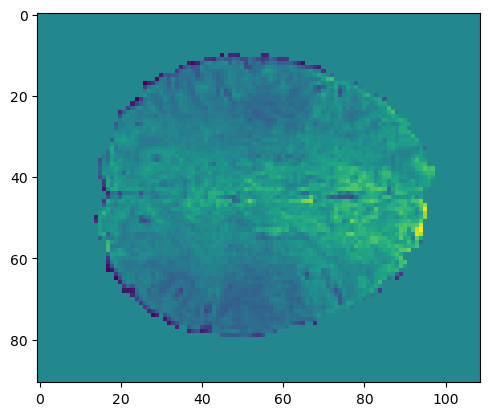

In [60]:
###- NORMALIZE SLICES -###

# only takes slices with intensity (everything but bg)
nonzero = slice[slice > 0]

# takes only black spaces (all bg)
back = slice == 0

# takes the mean and standard deviation of the brain component
m_, std_ = nonzero.mean(), nonzero.std()

# normalize 
norm_slice = (slice - m_) / std_
norm_slice[back] = 0
print(norm_slice.min(), norm_slice.mean(), norm_slice.max(), norm_slice.shape)
plt.imshow(norm_slice)
np.save('ground_truth.npy', norm_slice)
min_val = norm_slice.min()
max_val = norm_slice.max()

# stretch the values to fill the 0-255 range for the image
scaled_slice = 255 * (norm_slice - min_val) / (max_val - min_val)

# convert the scaled data to unsigned 8-bit integers 
image_array = scaled_slice.astype(np.uint8)
print(image_array.min(), image_array.max(), image_array.shape)

# create an image from the array and save it
img = Image.fromarray(image_array)
img.save('ground_truth.jpg')

The image resolution is: 109x91


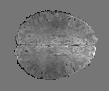

In [61]:
###--Load image with PIL and display--###
image_path = "./ground_truth.jpg"
image = Image.open(image_path)
W, H = image.size


#downsampling if necessary
#H = H//10
#W = W//10

image = image.resize((W, H))

# Print the dimensions
print(f"The image resolution is: {W}x{H}")
image.show()

## Dataframe

In [62]:
###- BUILD DATAFRAME -###

bw_array = norm_slice.T  # transpose to (height, width)

height, width = bw_array.shape
print(f"Shape of transposed slice: {bw_array.shape}")

# Create coordinate grids
x_coords, y_coords = np.meshgrid(np.arange(height), np.arange(width))

# Flatten everything and create df
x_flat = x_coords.ravel()
y_flat = y_coords.ravel()
intensity_z1_flat = bw_array.ravel()


min_int = np.min(intensity_flat)
max_int = np.max(intensity_flat)
print(max_int)
print(min_int)
df = pd.DataFrame({
    "x_pos": x_flat/(height-1),
    "y_pos": y_flat/(width-1),
    # [0 to 1] standardization    
    "intensity": (intensity_flat - min_int)/(max_int - min_int) # /np.max(intensity_flat) dividing by max is required for min-max scaling
})

df.head()


Shape of transposed slice: (109, 91)
5.128954352209998
-4.463201462811106


,x_pos,y_pos,intensity
0,0.000000,0.0,0.465297
1,0.009259,0.0,0.465297
2,0.018519,0.0,0.465297
3,0.027778,0.0,0.465297
4,0.037037,0.0,0.465297


In [63]:
# count, mean, max, etc. for the 'intensity' column
df.describe()

,x_pos,y_pos,intensity
count,9919.00000,9919.000000,9919.000000
mean,0.50000,0.500000,0.465297
std,0.29135,0.291880,0.070238
min,0.00000,0.000000,0.000000
25%,0.25000,0.244444,0.465297
50%,0.50000,0.500000,0.465297
75%,0.75000,0.755556,0.465297
max,1.00000,1.000000,1.000000


## Model Definition

In [64]:
###- INR IMAGE ARCHITECTURE -###

class ImageINRModel(torch.nn.Module):

    # nn constructor
    def __init__(self, input_size, hidden_size = 256, output_size = 1, num_hidden = 4):
        super(ImageINRModel, self).__init__()
        # input - 2 - x,y
        # hidden_size - 256 - num of hidden neurons
        # output - 1 - intensity
        # num_hidden - 4 - num of hidden layers

        # creates first fully-connected layer
        self.input = torch.nn.Linear(input_size, hidden_size)

        # builds hidden network layers
        layers = []
        for _ in range(num_hidden):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
        self.hidden = nn.Sequential(*layers)
        self.output = torch.nn.Linear(hidden_size, output_size)   
        self.sig = torch.nn.Sigmoid()


    def forward(self, x):
        x = self.input(x)
        x = self.hidden(x)
        x = self.output(x)
        x = self.sig(x)

        return x


class fMRI_INRModel(torch.nn.Module):
    # nn constructor
    def __init__(self, input_size, hidden_size = 256, output_size = 1, num_hidden = 4):
        super(fMRI_INRModel, self).__init__()
        # input - 2 - x,y
        # hidden_size - 256 - num of hidden neurons
        # output - 1 - intensity
        # num_hidden - 4 - num of hidden layers

        # creates first fully-connected layer
        self.input = torch.nn.Linear(input_size, hidden_size)

        # builds hidden network layers
        layers = []
        for _ in range(num_hidden):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
        self.hidden = nn.Sequential(*layers)
        self.output = torch.nn.Linear(hidden_size, output_size)   
        # self.sig = torch.nn.Sigmoid()


    def forward(self, x):
        x = self.input(x)
        x = self.hidden(x)
        x = self.output(x)
        # x = self.sig(x)

        return x

## Dataset Definition

In [65]:
#Dataset where input is simply [x,y] tensor
class ImageINRDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.x = torch.tensor(dataframe[['x_pos', 'y_pos']].values, dtype=torch.float32)
        self.y = torch.tensor(dataframe[['intensity']].values, dtype=torch.float32)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [66]:
#Dataset to customize type of positional encoding of input
class ImageINRDatasetFourier(Dataset):
    def __init__(self, dataframe, fourier = False, gaussian = False, num_freq = 1, freq_param = None, freq_file = 'freq.pkl', gauss_scale = 1):
        self.dataframe = dataframe

        if (fourier or gaussian) == False:
            #No positional encoding, just x and y
            self.x = torch.tensor(dataframe[['x_pos', 'y_pos']].values, dtype=torch.float32)
        else:
            if fourier == True:
                #fourier encoding with just cos/sin 2x and 2y
                freq = [1, 1]
            elif gaussian == True:
                #normal random sample num_freq frequencies for cos and sin to include in positional encoding
                freq = np.random.normal(0, 1, size = num_freq*2)*gauss_scale

                #Need to save these frequencies because they must also be used for pos encoding inputs at inference time
                pickle.dump(freq, open(freq_file, "wb"))
            else:
                #if you want to pass in custom frequencies
                freq = freq_param

            x = dataframe['x_pos']
            y = dataframe['y_pos']
            xy = torch.tensor(np.stack([x, y], axis=-1), dtype = torch.float32)
            self.x = fourier_encode(xy, freq)

        self.y = torch.tensor(dataframe[['intensity']].values, dtype=torch.float32)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [67]:
#Pass in a frequency array and and xy grid, return cos/sin of 2x/f and 2y/f for f in freq
def fourier_encode(xy: torch.Tensor, freq: torch.Tensor) -> torch.Tensor:
    xy = xy.unsqueeze(1)
    freq1 = freq[0:len(freq)//2 ]
    freq2 = freq[len(freq)//2:]
    
    
    freq1 = torch.tensor(freq1, dtype = torch.float32).view(1, -1, 1)
    freq2 = torch.tensor(freq2, dtype = torch.float32).view(1, -1, 1)

    scaled1 = 2 * torch.pi * (1/freq1) * xy  
    scaled2 = 2 * torch.pi * (1/freq2) * xy  

    sin_feat = torch.sin(scaled1)  
    cos_feat = torch.cos(scaled2)  


    features = torch.cat([sin_feat, cos_feat], dim=-1)  
    return features.view(xy.shape[0], -1)  

# train the model

In [68]:
#Function to train with different encoding types, set model_type to use different encodings
#STAF is a new INR that uses trainable parameter sinusoidal activation functions, just wanted to experiment with it: https://arxiv.org/abs/2502.00869
from tqdm import tqdm
import pickle
def train( num_freq, model_type, model_file = 'checkpoint.pth', loss_file = 'losses', freq_file = 'freq.pkl', gauss_scale = 1):
    epoch_losses = []
    valid_epoch_losses = []
    min_loss = 100
    
    if model_type == 'fourier':
        data = ImageINRDatasetFourier(df, fourier = True, num_freq = 1)
        model = ImageINRModel(input_size = 4).to(device)
    elif model_type == 'standard':
        data = ImageINRDataset(df)
        # model = ImageINRModel(input_size = 2).to(device)
        model = fMRI_INRModel(input_size = 2).to(device)
    elif model_type == 'gaussian':
        data = ImageINRDatasetFourier(df, gaussian = True, num_freq = num_freq, freq_file = freq_file, gauss_scale = gauss_scale)
        ###Thilina Edit: We forgot to change this from ImageINRModel to fMRI_INRModel
        #model = ImageINRModel(input_size = 4*num_freq).to(device)
        model = fMRI_INRModel(input_size = 4*num_freq).to(device)
    elif model_type == 'STAF':
        data = ImageINRDataset(df)
        model = INR(2, 256, 4, 1).to(device)
    else:
        print('invalid model_type')
        return
    
    train_dataloader = DataLoader(data, batch_size=8192, shuffle=True)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    # optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    num_epochs = 2000

    for epoch in tqdm(range(num_epochs)):
        model.train()

        epoch_loss = 0

        # training part
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)


            epoch_loss += loss.item()

            loss.backward()
            optimizer.step()

        # validation part
        # with torch.no_grad():
        #     for i, (inputs, labels) in enumerate(valid_dataloader):
        #         inputs, labels = inputs.to(device), labels.to(device)
        #         outputs = model(inputs)
        #         loss = criterion(outputs, labels)
        #         valid_epoch_loss += loss.item()

        if epoch % 200 == 0:
            print(f"Epoch {epoch}, Loss: {epoch_loss / len(train_dataloader)}")
            # add valid loss to the print function
            epoch_losses.append(epoch_loss)
            pickle.dump(epoch_losses, open(f"{loss_file}_losses.pkl", "wb"))
            if epoch_loss < min_loss:

                checkpoint = {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss,
                    # Add other relevant information as needed
                }
                

                torch.save(checkpoint, model_file)

In [ ]:
train(num_freq = 256, model_type = 'gaussian', model_file ='gaussian_run.pth', loss_file = 'gaussian_loss', freq_file = 'gau.pkl', gauss_scale = 10)

  0%|          | 1/2000 [00:00<19:22,  1.72it/s]

Epoch 0, Loss: 0.12163851782679558


 10%|█         | 201/2000 [00:21<03:38,  8.24it/s]

Epoch 200, Loss: 0.004611450945958495


 20%|██        | 401/2000 [00:42<03:06,  8.57it/s]

Epoch 400, Loss: 0.00312252773437649


 30%|███       | 601/2000 [01:03<02:39,  8.77it/s]

Epoch 600, Loss: 0.001259263081010431


 40%|████      | 801/2000 [01:24<02:16,  8.78it/s]

Epoch 800, Loss: 0.0006067200447432697


 50%|█████     | 1001/2000 [01:45<01:52,  8.85it/s]

Epoch 1000, Loss: 0.000372073074686341


 60%|██████    | 1201/2000 [02:06<01:28,  9.00it/s]

Epoch 1200, Loss: 0.0001237250180565752


 61%|██████    | 1211/2000 [02:07<01:12, 10.86it/s]

# visualization

109 91
torch.Size([9919, 1024])
torch.Size([9919, 1]) 109 91
min max of image tensor(-0.0103) tensor(1.0062) <class 'torch.Tensor'>
real diff from df tensor(0.0042)
The image resolution is: 109x91
reconstructed


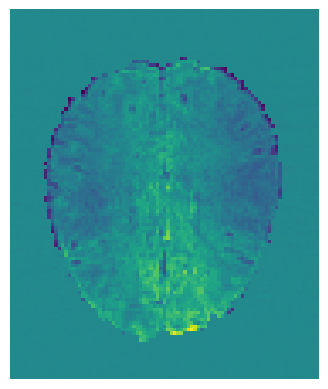

gt


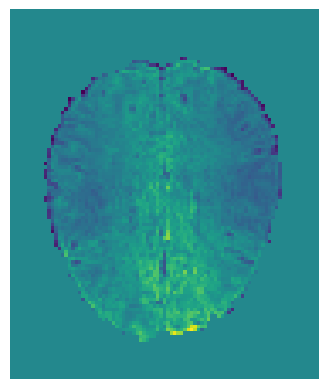

dif


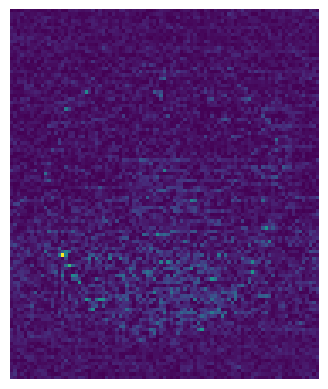

In [70]:
# model = fMRI_INRModel(input_size = 2)

# Use this for fourier
#model = ImageINRModel(input_size = 4) 

# use this for gaussian or passing in custom frequencies, change this to correct number of frequencies from training
num_freq = 256
model = fMRI_INRModel(input_size = 4*num_freq) 

#model = INR(2, 256, 4, 3) #Use this as model if evaluating STAF model

#define path to model checkpoint 
path = './gaussian_run.pth' 
checkpoint = torch.load(path)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()
print(W,H)
x = np.linspace(0, 1, W)
y = np.linspace(0, 1, H)
xx, yy = np.meshgrid(x, y)  # shape: (H, W)

X = torch.tensor(np.stack([xx, yy], axis=-1).reshape(-1, 2), dtype = torch.float32)  # shape: (H*W, 2)

# Use this for gaussian to load corresponding frequencies, otherwise comment out
with open('./gau.pkl', 'rb') as file:
    freq = pickle.load(file)

X = fourier_encode(X, freq = freq) # comment this line out if using standard or STAF, use freq = [1, 1] for fourier or freq = freq for gaussian
print(X.shape)
with torch.no_grad():
    Y = model(X) 

image = Y.reshape(W, H, 1) # [9019, 1] -> [91, 109, 1]
print(Y.shape, W, H)
print('min max of image',image.min(), image.max(), type(image))

gt_df = torch.Tensor(df.intensity).reshape(W,H,1)
gt_df_diff = torch.sum(torch.abs(gt_df - image), axis=2)
print('real diff from df', gt_df_diff.mean())
# gt = Image.open("./ground_truth.jpg")
#W, H = gt.size[0]//10, gt.size[1]//10 #if you downsampled the training image
# gt = gt.resize((W, H))

# to_tensor = transforms.ToTensor()
# gt = to_tensor(gt)
# gt = rearrange(gt, 'k i j -> i j k')
# gt = np.load('ground_truth.npy')[...,np.newaxis].transpose(1,0,2)
# print('min max of gt',gt.min(), gt.max(), gt.shape)
# dif = torch.sum(torch.abs(torch.Tensor(gt) - image), axis = 2)
# print('diff', dif.mean())

print(f"The image resolution is: {W}x{H}")

print('reconstructed')
plt.imshow(image)
plt.axis('off')
plt.show()

print('gt')
plt.imshow(gt_df)
plt.axis('off')
plt.show()

# plt.imshow(gt)
# plt.axis('off')
# plt.show()

print('dif')
plt.imshow(gt_df_diff)
plt.axis('off')
plt.show()

